<a href="https://colab.research.google.com/github/ononoimoco/first-git/blob/master/morebetterstyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'My Drive'


In [0]:
!ls 'drive/My Drive/longterm/development/data/'

ウェーブ  ストレート  ナチュラル


In [0]:
path = 'drive/My Drive/longterm/development/data'

In [0]:
from glob import glob
folders = sorted(glob('{}/*'.format(path)))

In [0]:
folders

['drive/My Drive/longterm/development/data/ウェーブ',
 'drive/My Drive/longterm/development/data/ストレート',
 'drive/My Drive/longterm/development/data/ナチュラル']

In [0]:
import sys

In [0]:
print('Hello, Colaboratory from Python {}!'.format(sys.version_info[0]))

Hello, Colaboratory from Python 3!


In [0]:
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'My Drive'


In [0]:
!ls 'drive/My Drive/longterm/development/'

data  result


In [0]:
path = 'drive/My Drive/longterm/development'

In [0]:
import numpy as np
import cv2

In [0]:
filepaths, x, t= [], [], []
for i, folder in enumerate(folders):
    filepaths = glob('{}/*'.format(folder))
    for filepath in filepaths:
        try:
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = img.astype('f').transpose(2,0,1)
            x.append(img)
            t.append(np.array(i, 'i'))
        except Exception as e:
            print(e, filepath, 'error')

In [0]:
from chainer.datasets import TupleDataset

In [0]:
dataset = TupleDataset(x,t)

In [0]:
from chainer.datasets import split_dataset_random
n_train = int(len(dataset)*0.6)
train_val,test = split_dataset_random(dataset,n_train,seed=0)
n_train = int(len(train_val)*0.6)
train,valid = split_dataset_random(train_val,n_train,seed=0)

In [0]:
len(train)

76

In [0]:
len(valid)

51

In [0]:
len(test)

85

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F
import random
import numpy as np

In [0]:
class CNN(chainer.Chain):

    def __init__(self, n_mids=40, n_out=20):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=32, ksize=3, pad=1)
            self.conv2 = L.Convolution2D(in_channels=32, out_channels=64, ksize=3, pad=1)
            self.fc1 = L.Linear(None, n_mids)
            self.fc2 = L.Linear(None, n_out)
            self.bn1 = L.BatchNormalization(3)
            self.bn2 = L.BatchNormalization(32)

    def __call__(self, x):
        h = self.bn1(x)
        h = F.relu(self.conv1(h))
        h = F.max_pooling_2d(h, 3, 3)
        h = self.bn2(h)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 3, 3)
        h = self.fc1(h)
        h = self.fc2(h)
        return h

In [0]:
def reset_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(seed)

In [0]:
reset_seed(0)

In [0]:
gpu_id = 0
model = L.Classifier(CNN())

In [0]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
model.to_gpu(gpu_id)


In [0]:
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)

In [0]:
epoch = 20
updater = chainer.training.StandardUpdater(train_iter,optimizer,device = gpu_id)

In [0]:
from chainer.training import extensions
trainer = chainer.training.Trainer(updater, ( epoch,'epoch'),out='{}/result'.format(path))

trainer.extend(extensions.Evaluator(valid_iter,model,device=gpu_id))

In [0]:
trainer.extend(extensions.LogReport(log_name='log_simplecnn'))
trainer.extend(extensions.PrintReport(['epoch','elapsed_time','validation/main/loss','main/accuracy','validation/main/accuracy']), trigger=(1, 'epoch'))

In [0]:
trainer.run()

epoch       elapsed_time  validation/main/loss  main/accuracy  validation/main/accuracy
1           8.417         90.4587               0.325          0.421212                  
2           8.71739       43.4075               0.7375         0.421212                  
3           8.98134       14.6865               0.725          0.387879                  
4           9.25253       6.22681               0.6375         0.537879                  
5           9.45496       8.16039               0.883333       0.457576                  
6           9.70461       6.46411               0.8875         0.551515                  
7           9.95433       7.93827               0.8875         0.634849                  
8           10.2003       6.00639               0.9            0.518182                  
9           10.452        6.76812               0.9125         0.507576                  
10          10.6539       4.99601               0.966667       0.390909                  
11          

In [0]:
!nvidia-smi

Sat Sep 21 10:25:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    87W / 149W |    701MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import json
import pandas as pd
with open('{}/result/log_simplecnn'.format(path)) as f:
  result = pd.DataFrame(json.load(f))
result.tail(5)

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
15,12.112835,16,61,0.975000,0.257847,0.474242,7.368839
16,12.370715,17,65,0.987500,0.177569,0.584848,6.894739
17,12.614626,18,69,0.987500,0.027516,0.587879,8.218684
18,12.867900,19,73,0.987500,0.158278,0.571212,8.432359
19,13.068435,20,76,0.983333,0.174260,0.587879,7.749695


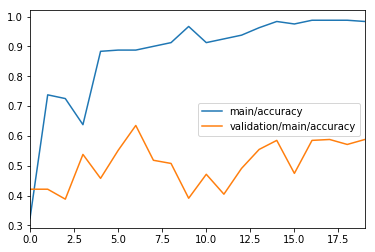

In [0]:
result[['main/accuracy','validation/main/accuracy']].plot()

In [0]:
import numpy as np

In [0]:
import cv2

In [0]:
import pandas as pd

In [0]:
import random

In [0]:
import json

In [0]:
import chainer

In [0]:
import chainer.functions as F

In [0]:
import chainer.links as L

In [0]:
from chainer.datasets import split_dataset_random, TupleDataset
from chainer.training import extensions

In [0]:
# path = 'drive/My Drive/longterm/week10/data/' # よく使用するpathを変数に入れておくと便利です。
from glob import glob
folders = sorted(glob('{}/*'.format(path)))


In [0]:
from chainer.links import GoogLeNet
from chainer.links.model.vision.googlenet import prepare

In [0]:
def prepare_data_google(folders):
  filepaths, x, t= [], [], []
  for i, folder in enumerate(folders):
    filepaths = glob('{}/*'.format(folder))
    for filepath in filepaths:
      try:
        img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
        img = prepare(img) # 画像の前処理の部分を変更
        x.append(img)
        t.append(np.array(i, 'i'))
      except Exception as e:
        print(e, filepath, 'error')
  return x, t

In [0]:
x, t = prepare_data_google(folders)

In [0]:
dataset = TupleDataset(x, t)

In [0]:
n_train = int(len(dataset)*0.8)
train_val, test = split_dataset_random(dataset, n_train, seed=0)
n_train = int(len(train_val)*0.7)
train, valid = split_dataset_random(train_val, n_train, seed=0)

In [0]:
class GoogleNet(chainer.Chain):

    def __init__(self, n_out=3):
        super().__init__()
        with self.init_scope():
            self.base = L.GoogLeNet()
            self.fc = L.Linear(None, n_out)

    def __call__(self, x):
        h = self.base(x, layers=['pool5'])
        h = self.fc(h['pool5'])
        return h

In [0]:
def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

In [0]:
reset_seed(0)

In [0]:
gpu_id = 0
model = L.Classifier(GoogleNet())
model.to_gpu(gpu_id)

In [0]:
alpha = 1e-4

optimizer = chainer.optimizers.Adam(alpha=alpha)
optimizer.setup(model)

model.predictor['fc'].W.update_rule.hyperparam.alpha = alpha * 10
model.predictor['fc'].b.update_rule.hyperparam.alpha = alpha * 10

In [0]:
batchsize = 30
train_iter = chainer.iterators.SerialIterator(train, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid, batchsize, repeat=False, shuffle=False)

In [0]:
epoch = 30
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [0]:
trainer = chainer.training.Trainer(updater, (epoch, 'epoch'), out='{}/result'.format(path))

trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))
trainer.extend(extensions.LogReport(log_name='log_gnet_finetune'))
# trainer.extend(extensions.PrintReport(['epoch','elapsed_time','main/loss','validation/main/loss','main/accuracy']), trigger=(1,'epoch'))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [0]:
trainer.run()

epoch       iteration   main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           4           0.508333       0.595238                  1.06885     0.851719              1.89787       
2           8           0.841667       0.709524                  0.484374    0.7033                3.74203       
3           12          0.9            0.733333                  0.247059    0.662777              5.58134       
4           16          0.975          0.709524                  0.135187    0.625265              7.41582       
5           20          0.975          0.766667                  0.060123    0.755543              9.25488       
6           24          0.975          0.75                      0.0373522   0.839195              11.1281       
7           28          0.983333       0.77381                   0.0386739   0.952784              12.9755       
8           32          0.975          0.790476                  0.0806275   0.904189     

In [0]:
import json
import pandas as pd
with open('{}/result/log_gnet_finetune'.format(path)) as f:
  result = pd.DataFrame(json.load(f))
result.tail(5)

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
25,47.573436,26,103,0.983333,0.018228,0.766667,0.912421
26,49.405197,27,107,0.966667,0.036076,0.766667,0.922152
27,51.251918,28,111,0.991667,0.022592,0.766667,0.919347
28,53.087103,29,115,0.983333,0.022757,0.766667,0.930419
29,54.550425,30,118,0.977778,0.026615,0.807143,0.963175


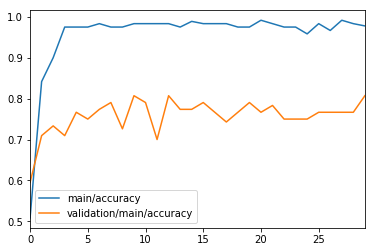

In [0]:
result[['main/accuracy','validation/main/accuracy']].plot()